In [1]:
 
pip install shap

Note: you may need to restart the kernel to use updated packages.


In [2]:
#IMPORTING VARIOUS PYTHON LIBRARIES AND MODULES
import numpy as np
import cv2
import os
import random
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.utils import resample
import matplotlib.pyplot as plt
import shap
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [3]:
#DIRECTORY WHERE DATASET IS LOCATED
Dataset_Dir ="/Users/anjalibhardwaj/Desktop/College/Deep Learning/assignment 2/Val"

In [4]:
#LIST THE CONTENT OF DIRECTORY
os.listdir("/Users/anjalibhardwaj/Desktop/College/Deep Learning/assignment 2/Val")

['.DS_Store', 'Non-COVID', 'COVID-19', 'Normal']

In [5]:
# Define DIRECTORY paths
covid_images_path = '/Users/anjalibhardwaj/Desktop/College/Deep Learning/assignment 2/Val/Covid-19/images'
non_covid_images_path = '/Users/anjalibhardwaj/Desktop/College/Deep Learning/assignment 2/Val/Non-Covid/images'
normal_images_path = '/Users/anjalibhardwaj/Desktop/College/Deep Learning/assignment 2/Val/Normal/images'


In [6]:
# Load and preprocess images , convert it to greyscale resize it, 
#and perform histogram equlization, applies gaussian liur
def load_and_preprocess_images(folder, target, size=(200, 200)):
    images = []
    labels = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        if img_path.endswith('.png') or img_path.endswith('.jpg'):
            img = cv2.imread(img_path)
            if img is not None:
                gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                resized_img = cv2.resize(gray_img, size)
                # Histogram equalization
                equalized_img = cv2.equalizeHist(gray_img)
                # Gaussian Blur
                blurred_img = cv2.GaussianBlur(equalized_img, (5, 5), 0)
                
                images.append(blurred_img)
                labels.append(target)
    return images, labels

In [7]:
# Load and process  images from each category
covid_images, covid_labels = load_and_preprocess_images(covid_images_path, 'COVID-19')
non_covid_images, non_covid_labels = load_and_preprocess_images(non_covid_images_path, 'Non-COVID')
normal_images, normal_labels = load_and_preprocess_images(normal_images_path, 'Normal')


In [8]:
# Combine all prprocessed images and labels
all_images = np.r_[covid_images, non_covid_images, normal_images]
all_labels = np.r_[covid_labels, non_covid_labels, normal_labels]


In [9]:
# Resize images
def resize_images(images, size=(200, 200)):
    resized_images = []
    for img in images:
        resized_img = cv2.resize(img, size)
        resized_images.append(resized_img)
    return resized_images


In [10]:
#resize all image stored in all_images
resized_images = resize_images(all_images)

In [11]:
# Convert labels to numerical format
label_mapping = {'COVID-19': 0, 'Non-COVID': 1, 'Normal': 2}
numeric_labels = [label_mapping[label] for label in all_labels]


In [12]:
# Convert to numpy array
X = np.array(resized_images)
y = np.array(numeric_labels)


In [13]:
#print shape of numpy array containing image data
print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")


Shape of X: (5417, 200, 200)
Shape of y: (5417,)


In [14]:
# split the data set into train and test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [15]:
# Perform class Balancing by randomly sampling from minority classes
X_train_balanced = []
y_train_balanced = []


In [16]:
# Define size of the majority class
majority_class_size = 5000

In [17]:
# Balance  COVID-19 class
covid_indices = np.where(y == 0)[0]
covid_sampled_indices = np.random.choice(covid_indices, size=majority_class_size, replace=True)
X_train_balanced.extend(X[covid_sampled_indices])
y_train_balanced.extend(y[covid_sampled_indices])

In [18]:
# Balance  Non-COVID class
non_covid_indices = np.where(y == 1)[0]
non_covid_sampled_indices = np.random.choice(non_covid_indices, size=majority_class_size, replace=True)
X_train_balanced.extend(X[non_covid_sampled_indices])
y_train_balanced.extend(y[non_covid_sampled_indices])


In [19]:
# Balance Normal class
normal_indices = np.where(y == 2)[0]
normal_sampled_indices = np.random.choice(normal_indices, size=majority_class_size, replace=True)
X_train_balanced.extend(X[normal_sampled_indices])
y_train_balanced.extend(y[normal_sampled_indices])

In [20]:
# Converting to NumPy arrays
X_train_balanced = np.array(X_train_balanced)
y_train_balanced = np.array(y_train_balanced)

In [21]:
# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
 )

In [22]:
# Fitting datagen on the balanced dataset with additional dimension added using np.newaxis
datagen.fit(X_train_balanced[..., np.newaxis])

In [40]:
# Define the DNN model architecture, batch normalization are added after each dence layer to stabalize and accelerate the training process
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization
model = Sequential([
    Flatten(input_shape=(200, 200, 1)),           # Flatten layer converts 2D input to 1D
    Dense(256, activation='relu'),                # fully connected layer with 256 units and ReLU activation
    BatchNormalization(),                         # Batch normalization layer
    Dropout(0.5),                                  # Dropout layer with dropout rate of 0.5
    Dense(128, activation='relu'),                # Another fully connected layer with 128 units and ReLU activation
    BatchNormalization(),                         # batch normalization layer
    Dropout(0.3),                                  # Dropout layer with dropout rate of 0.3
    Dense(64, activation='relu'),                 # Another fully connected layer with 64 units and ReLU activation
    BatchNormalization(),                         # Batch normalization layer
    Dense(3, activation='softmax')                 # Output layer with 3 units for classification and softmax activation
])

In [41]:
# Compiling the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [42]:
# Train the model. training is performed for 10 epoches
history = model.fit(datagen.flow(X_train_balanced[..., np.newaxis], y_train_balanced, batch_size=32),
                    validation_data=(X_test[..., np.newaxis], y_test),
                    epochs=10,
                    steps_per_epoch=len(X_train_balanced) // 32)


Epoch 1/10
468/468 [==============================] - 22s 46ms/step - loss: 1.0893 - accuracy: 0.4522 - val_loss: 0.9374 - val_accuracy: 0.5120
Epoch 2/10
468/468 [==============================] - 22s 46ms/step - loss: 1.0006 - accuracy: 0.5007 - val_loss: 0.8777 - val_accuracy: 0.6162
Epoch 3/10
468/468 [==============================] - 22s 47ms/step - loss: 0.9834 - accuracy: 0.5091 - val_loss: 0.8997 - val_accuracy: 0.5923
Epoch 4/10
468/468 [==============================] - 21s 46ms/step - loss: 0.9710 - accuracy: 0.5251 - val_loss: 0.8686 - val_accuracy: 0.5886
Epoch 5/10
468/468 [==============================] - 22s 46ms/step - loss: 0.9609 - accuracy: 0.5283 - val_loss: 0.8867 - val_accuracy: 0.5803
Epoch 6/10
468/468 [==============================] - 22s 47ms/step - loss: 0.9588 - accuracy: 0.5281 - val_loss: 0.8769 - val_accuracy: 0.5784
Epoch 7/10
468/468 [==============================] - 23s 48ms/step - loss: 0.9635 - accuracy: 0.5225 - val_loss: 1.0502 - val_accuracy:

In [43]:
# Evaluate the train  model on testing data
test_loss, test_acc = model.evaluate(X_test[..., np.newaxis], y_test, verbose=2)
print("\nTest accuracy:", test_acc)

34/34 - 0s - loss: 0.8475 - accuracy: 0.6144 - 140ms/epoch - 4ms/step

Test accuracy: 0.6143911480903625


In [44]:
# Generate predictions for testing data
y_pred = model.predict(X_test[..., np.newaxis])
y_pred_classes = np.argmax(y_pred, axis=1)


34/34 [==============================] - 0s 5ms/step


In [45]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

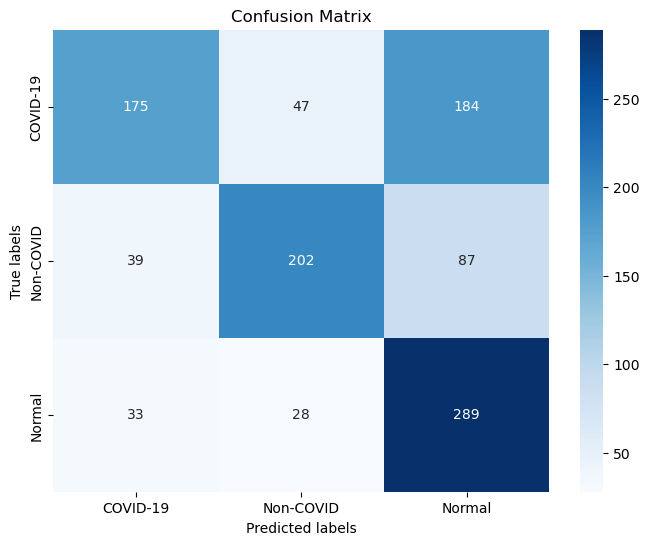

In [46]:
# plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=['COVID-19', 'Non-COVID', 'Normal'], yticklabels=['COVID-19', 'Non-COVID', 'Normal'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


In [47]:
# compute AUC for each class
from sklearn.metrics import roc_auc_score, roc_curve
auc_scores = []
for i in range(3):
    auc_scores.append(roc_auc_score((y_test == i).astype(int), y_pred[:, i]))


In [48]:
# printing AUC scores
for i, score in enumerate(auc_scores):
    print(f'AUC for class {i}: {score}')

AUC for class 0: 0.8031155092491681
AUC for class 1: 0.8396365660085172
AUC for class 2: 0.8137368625924484


In [49]:
from sklearn.metrics import roc_curve, auc
# compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve((y_test == i).astype(int), y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


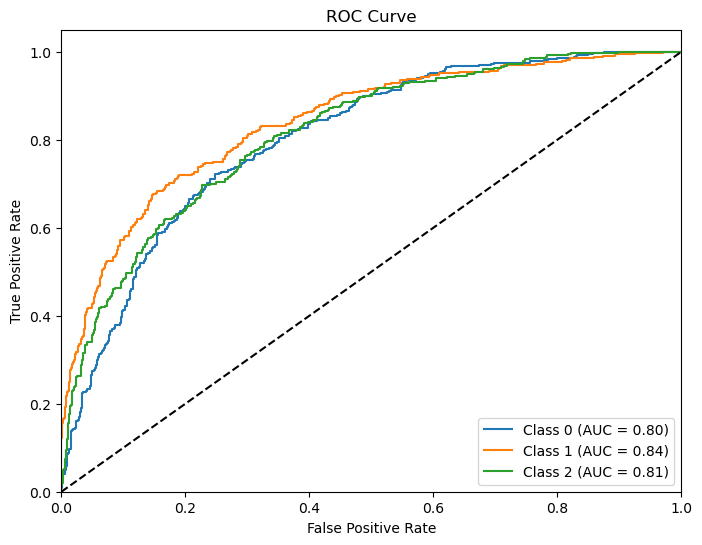

In [50]:
# Plot ROC curve for each class
plt.figure(figsize=(8, 6))
for i in range(3):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [34]:
# select  few samples to explain
sample_indices = [0, 1, 2]  
X_samples = X_test[sample_indices]
y_samples = y_test[sample_indices]

In [35]:
# SHAP explanations
# Using a subset of training data for background
background = np.tile(X_train_balanced[..., np.newaxis], (len(X_samples), 1, 1, 1))  # Reshape background to match the shape of X_samples
  

In [36]:
# Create SHAP 
explainer = shap.DeepExplainer(model, background)


/Users/anjalibhardwaj/anaconda3/lib/python3.11/site-packages/shap/explainers/_deep/deep_tf.py:99: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn("Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.")
/Users/anjalibhardwaj/anaconda3/lib/python3.11/site-packages/shap/explainers/_deep/deep_tf.py:155: UserWarning: You have provided over 5k background samples! For better performance consider using smaller random sample.
  warnings.warn("You have provided over 5k background samples! For better performance consider using smaller random sample.")


In [38]:
# Compute SHAP values for the samples
#shap_values = explainer.shap_values(X_samples)

In [ ]:
# Plot SHAP values for each class
for i in range(len(shap_values)):
    shap.image_plot(shap_values[i], X_samples)